<a href="https://colab.research.google.com/github/Saumi18/Music-Genre-Classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload the features_3_sec.csv file below:

In [5]:
#Upload the features_3_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_3_sec.csv to features_3_sec.csv


Upload the feature_30_sec.csv file below:

In [6]:
#Upload the feature_30_sec.csv file here
from google.colab import files
uploaded = files.upload()

Saving features_30_sec.csv to features_30_sec.csv


- Setting Up & Loading Data
- Feature Scaling & Preprocessing

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [8]:
# Drop unnecessary columns
df = df.drop(columns=["filename", "length"])

# Encode genre labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # Encode genres as numbers

# Separate features (X) and labels (y)
X = df.drop(columns=["label"])
y = df["label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

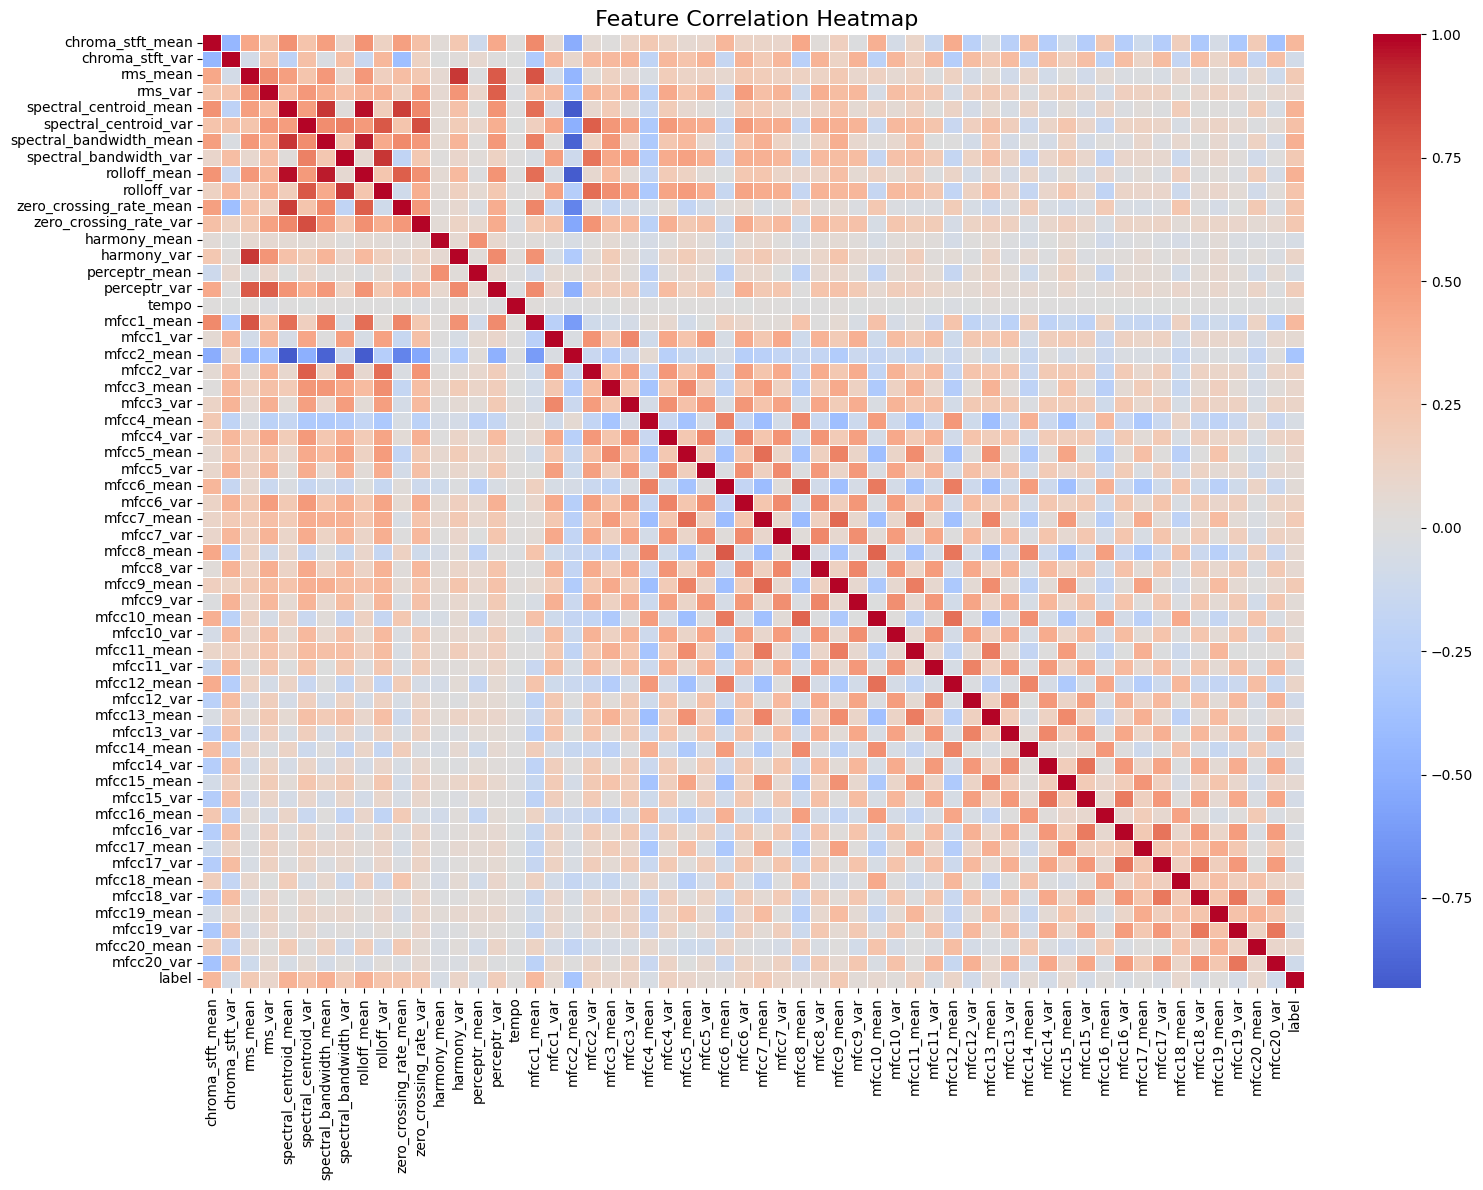

In [9]:
# Compute the correlation matrix (excluding non-numeric columns)
corr_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(" Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

Model 1 : KNN

Accuracy for k=3: 0.9555


Text(0, 0.5, 'Accuracy')

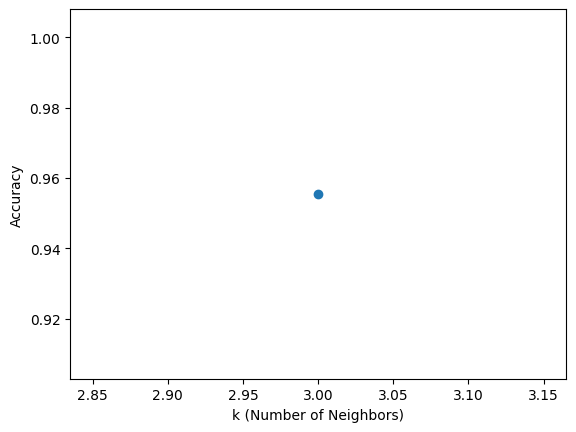

In [ ]:
# Model 1: KNN
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

def euclidean_distance(point1, point2):
    """Calculates the Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2)**2))

def get_k_nearest_neighbors(X_train, y_train, test_point, k):
    """Finds the k-nearest neighbors of a test point in the training data."""
    distances = [euclidean_distance(train_point, test_point) for train_point in X_train]
    k_nearest_indices = np.argsort(distances)[:k]  # Get indices of k-nearest neighbors
    # Access y_train using .iloc to ensure positional indexing
    k_nearest_labels = y_train.iloc[k_nearest_indices]  # Get labels of k-nearest neighbors
    return k_nearest_labels

def predict_label(neighbors):
    """Predicts the label of a test point based on its k-nearest neighbors."""
    # Use bincount to find the most frequent label
    labels, counts = np.unique(neighbors, return_counts=True)
    return labels[np.argmax(counts)]

def predict_all_points(X_train, y_train, X_test, k):
    """Predicts labels for all test points in X_test using KNN."""
    predictions = [predict_label(get_k_nearest_neighbors(X_train, y_train, test_point, k)) for test_point in X_test]
    return predictions

# Assuming you have already loaded and preprocessed your data as X_train, y_train

k_values = [3]
train_accuracies = []  # List to store training accuracies

for k in k_values:
    # Calculate training accuracy
    train_predictions = predict_all_points(X_train, y_train, X_train, k)  # Use X_train for training predictions
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)

    print(f"Accuracy for k={k}: {train_accuracy:.4f}")  # Print training accuracy



Confusion Matrix:
 [[191   1   4   0   1   3   0   0   3   5]
 [  0 196   0   0   0   7   0   0   0   0]
 [ 10   3 159   6   0   2   0   1   4   1]
 [  3   2   0 185   2   0   0   4   0   3]
 [  0   0   8   1 197   1   0   5   6   0]
 [  5  11   5   0   0 170   0   1   0   0]
 [  0   0   0   1   0   0 199   0   0   4]
 [  0   0   5   2   5   2   0 164   1   1]
 [  1   1   3   4   3   0   0   0 199   0]
 [  4   1   9   8   3   0   3   0   2 167]]
Precision: 0.9151515621753735
Recall: 0.9144144144144144


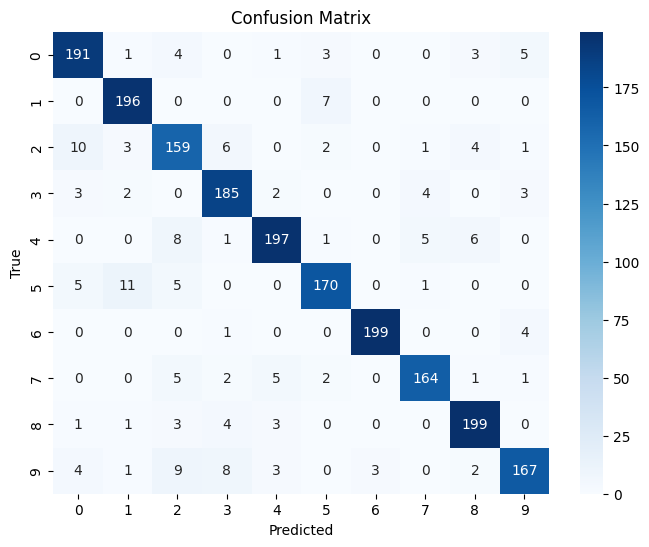

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Example: y_pred = predict_all_points(X_train, y_train, X_test, k=3)


# Example predictions (replace with your actual predictions):
k = 3
y_pred = predict_all_points(X_train, y_train, X_test, k)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision
precision = precision_score(y_test, y_pred, average='weighted') # Use 'weighted' or other averaging method as needed.
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred, average='weighted') # Use 'weighted' or other averaging method as needed.
print(f"Recall: {recall}")

# Plotting the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Model 2: SVM

Training class blues vs Rest...
Training class classical vs Rest...
Training class country vs Rest...
Training class disco vs Rest...
Training class hiphop vs Rest...
Training class jazz vs Rest...
Training class metal vs Rest...
Training class pop vs Rest...
Training class reggae vs Rest...
Training class rock vs Rest...
Testing class blues vs Rest...
Testing class classical vs Rest...
Testing class country vs Rest...
Testing class disco vs Rest...
Testing class hiphop vs Rest...
Testing class jazz vs Rest...
Testing class metal vs Rest...
Testing class pop vs Rest...
Testing class reggae vs Rest...
Testing class rock vs Rest...

Classification Report:
              precision    recall  f1-score   support

       blues       0.17      0.92      0.29       208
   classical       0.93      0.94      0.94       203
     country       0.88      0.12      0.22       186
       disco       0.00      0.00      0.00       199
      hiphop       0.88      0.44      0.59       218
        jazz 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


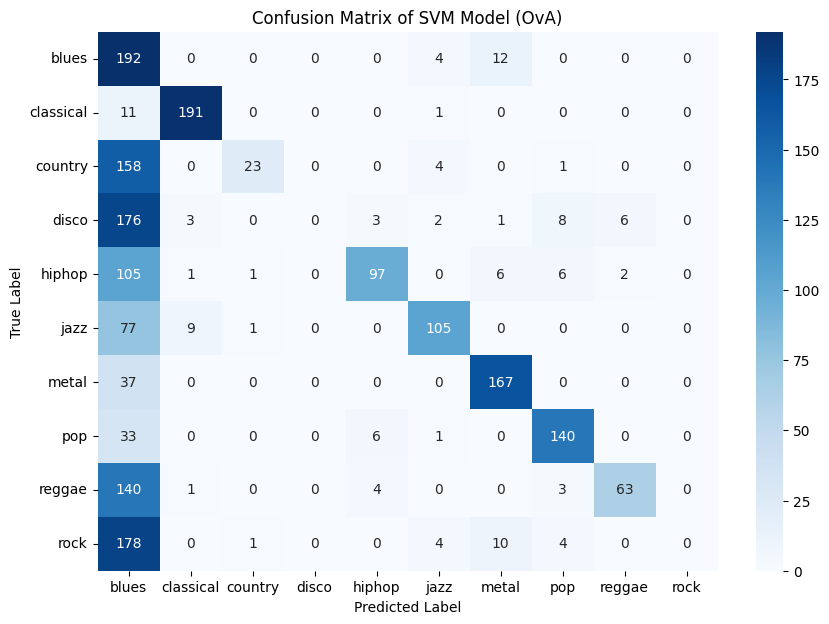

Testing class blues vs Rest...
Testing class classical vs Rest...
Testing class country vs Rest...
Testing class disco vs Rest...
Testing class hiphop vs Rest...
Testing class jazz vs Rest...
Testing class metal vs Rest...
Testing class pop vs Rest...
Testing class reggae vs Rest...
Testing class rock vs Rest...

Visual Testing Examples:
Example 1: Actual = hiphop, Predicted = hiphop
Example 2: Actual = pop, Predicted = pop
Example 3: Actual = rock, Predicted = blues
Example 4: Actual = reggae, Predicted = blues
Example 5: Actual = blues, Predicted = blues


In [ ]:
import random

# Implementing SVM from scratch with gradient descent
class SVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.weights) - self.bias) >= 1
                if condition:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
                else:
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - np.dot(x_i, y[idx]))
                    self.bias -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.weights) - self.bias)

# One-vs-All (OvA) SVM Model
class MultiClassSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=2000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}

    def fit(self, X, y):
        unique_classes = np.unique(y)
        for cls in unique_classes:
            print(f"Training class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            y_binary = np.where(y == cls, 1, -1)
            svm = SVM(lr=self.lr, lambda_param=self.lambda_param, n_iters=self.n_iters)
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm

    def predict(self, X):
        predictions = {}
        for cls, svm in self.classifiers.items():
            print(f"Testing class {label_encoder.inverse_transform([cls])[0]} vs Rest...")
            predictions[cls] = svm.predict(X)
        return np.array([max(predictions, key=lambda k: predictions[k][i]) for i in range(X.shape[0])])

# Train the custom SVM model
custom_svm = MultiClassSVM(lr=0.0005, lambda_param=0.001, n_iters=3000)
custom_svm.fit(X_train, y_train)

# Make predictions
y_pred = custom_svm.predict(X_test)

# Evaluate model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of SVM Model (OvA)")
plt.show()

# Select a few random test samples for visual testing
random_indices = random.sample(range(len(X_test)), 5)

# Predict the labels for these samples
y_test_samples = np.array(y_test)[random_indices]
y_pred_samples = custom_svm.predict(X_test[random_indices])

# Print actual vs predicted labels
print("\nVisual Testing Examples:")
for i, idx in enumerate(random_indices):
    actual_label = label_encoder.inverse_transform([y_test_samples[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_samples[i]])[0]
    print(f"Example {i+1}: Actual = {actual_label}, Predicted = {predicted_label}")

Model 3 : Decision tree/Random Forest

In [ ]:
import numpy as np
import math
from joblib import Parallel, delayed
from numba import njit

@njit
def gini_impurity(y):
    if len(y) == 0:
        return 0.0
    counts = np.bincount(y, minlength=np.max(y) + 1)
    probabilities = counts / len(y)
    return 1.0 - np.sum(probabilities**2)

@njit
def most_common_label(y):
    if len(y) == 0:
        return -1
    return np.bincount(y).argmax()

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class RandomForestClassifier:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.random_state = random_state
        self._rng = np.random.RandomState(random_state)
        self.trees = []

    def fit(self, X, y):
        if hasattr(y, "to_numpy"):
            y = y.to_numpy()
        X = np.asarray(X)
        self.n_classes = len(set(y))
        self.trees = Parallel(n_jobs=-1)(
            delayed(self._grow_tree)(
                *self._bootstrap_sample(X, y)
            ) for _ in range(self.n_trees)
        )

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = self._rng.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _grow_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(set(y)) == 1 or len(y) < self.min_samples_split:
            return Node(value=most_common_label(y))

        feature_indices = self._rng.choice(X.shape[1], self.n_features or int(math.sqrt(X.shape[1])), replace=False)
        best_feature, best_threshold = self._best_split(X, y, feature_indices)

        if best_feature == -1:
            return Node(value=most_common_label(y))

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        if not np.any(left_mask) or not np.any(right_mask):
            return Node(value=most_common_label(y))

        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature_index=best_feature, threshold=best_threshold, left=left, right=right)

    def _best_split(self, X, y, feature_indices):
        best_gain, best_feature, best_threshold = -1.0, -1, 0.0
        for feature_index in feature_indices:
            values = np.sort(np.unique(X[:, feature_index]))
            thresholds = (values[:-1] + values[1:]) / 2.0

            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if not np.any(left_mask) or not np.any(right_mask):
                    continue

                gain = gini_impurity(y) - (
                    (np.sum(left_mask) / len(y)) * gini_impurity(y[left_mask])
                    + (np.sum(right_mask) / len(y)) * gini_impurity(y[right_mask])
                )

                if gain > best_gain:
                    best_gain, best_feature, best_threshold = gain, feature_index, threshold

        return best_feature, best_threshold

    def predict(self, X):
        X = np.asarray(X)
        tree_preds = Parallel(n_jobs=-1)(
            delayed(self._batch_predict_tree)(X, tree) for tree in self.trees
        )
        tree_preds = np.array(tree_preds)
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=self.n_classes).argmax(), axis=0, arr=tree_preds)

    def _batch_predict_tree(self, X, tree):
        return np.array([self._traverse_tree(x, tree) for x in X])

    def _traverse_tree(self, x, tree):
        while tree is not None and tree.value is None:
            if x[tree.feature_index] <= tree.threshold:
                tree = tree.left
            else:
                tree = tree.right
        return tree.value if tree is not None else -1

    def predict_proba(self, X):
        X = np.asarray(X)
        tree_preds = np.array([self._batch_predict_tree(X, tree) for tree in self.trees])
        proba = np.apply_along_axis(lambda x: np.bincount(x, minlength=self.n_classes) / self.n_trees, axis=0, arr=tree_preds)
        return proba.T


In [ ]:
# Initialize classifier
clf = RandomForestClassifier(n_trees=56, max_depth=17, min_samples_split=5)

# Fit the model to your training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.8673673673673674


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model using classification_report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

       blues       0.83      0.88      0.85       208
   classical       0.93      0.99      0.96       203
     country       0.74      0.84      0.79       186
       disco       0.86      0.81      0.84       199
      hiphop       0.94      0.86      0.90       218
        jazz       0.86      0.90      0.88       192
       metal       0.89      0.94      0.91       204
         pop       0.88      0.93      0.91       180
      reggae       0.89      0.87      0.88       211
        rock       0.85      0.65      0.74       197

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



Confusion Matrix:
 [[182   0  15   1   0   6   1   0   3   0]
 [  1 200   0   0   0   1   0   0   0   1]
 [ 11   0 157   0   0  11   1   0   4   2]
 [  1   4   5 162   6   1   2   5   5   8]
 [  5   1   5   1 188   0   7   9   1   1]
 [  5   9   4   1   0 173   0   0   0   0]
 [  1   0   1   1   1   0 192   0   2   6]
 [  0   0   4   2   0   2   0 168   2   2]
 [  4   1   5   5   2   1   1   7 183   2]
 [  9   0  16  16   3   7  12   1   5 128]]


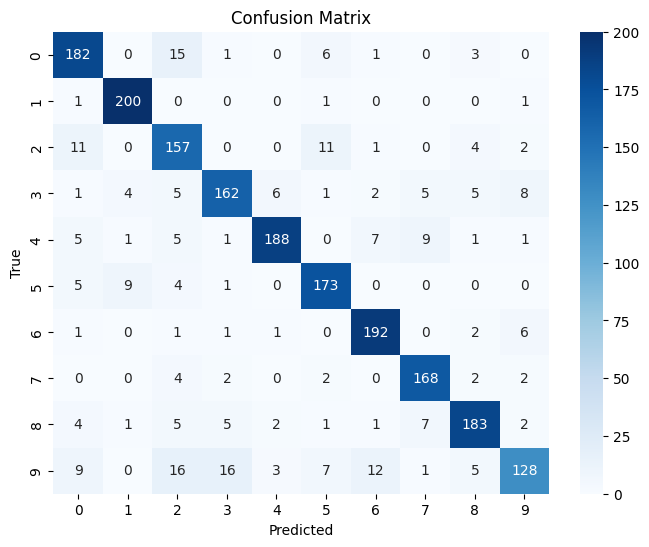

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
import random # Import the random module

# Select a few random test samples for visual testing
random_indices = random.sample(range(len(X_test)), 15)

# Predict the labels for these samples using the Random Forest model
y_test_samples = np.array(y_test)[random_indices]
y_pred_samples = clf.predict(X_test[random_indices])

# Print actual vs predicted labels
print("\nVisual Testing Examples (Random Forest):")
for i, idx in enumerate(random_indices):
    actual_label = label_encoder.inverse_transform([y_test_samples[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_samples[i]])[0]
    print(f"Example {i+1}: Actual = {actual_label}, Predicted = {predicted_label}")


Visual Testing Examples (Random Forest):
Example 1: Actual = classical, Predicted = classical
Example 2: Actual = reggae, Predicted = reggae
Example 3: Actual = country, Predicted = country
Example 4: Actual = pop, Predicted = pop
Example 5: Actual = jazz, Predicted = jazz
Example 6: Actual = hiphop, Predicted = hiphop
Example 7: Actual = disco, Predicted = disco
Example 8: Actual = metal, Predicted = metal
Example 9: Actual = pop, Predicted = pop
Example 10: Actual = blues, Predicted = blues
Example 11: Actual = hiphop, Predicted = pop
Example 12: Actual = hiphop, Predicted = hiphop
Example 13: Actual = disco, Predicted = rock
Example 14: Actual = hiphop, Predicted = hiphop
Example 15: Actual = rock, Predicted = blues


Model 4: Gaussian Mixture Model (GMM) + Expectation Maximization

Train Accuracy: 37.36%
Test Accuracy: 39.24%


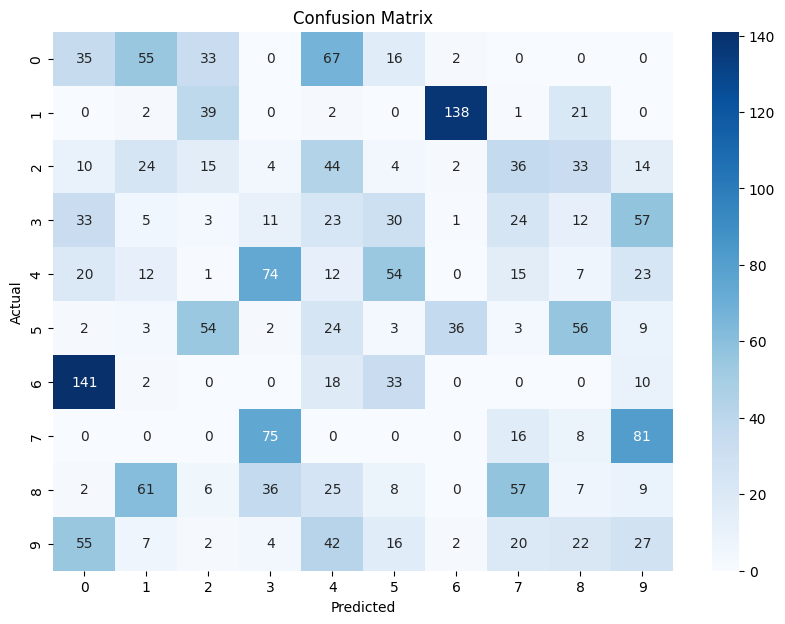

In [ ]:
# Model 4: Gaussian Mixture Model (GMM) + Expectation Maximization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode

def map_cluster_labels(y_true, y_pred):
    mapped_labels = np.zeros_like(y_pred)
    for cluster in np.unique(y_pred):
        mask = y_pred == cluster
        mapped_labels[mask] = mode(y_true[mask], keepdims=True).mode[0]
    return mapped_labels

class GaussianMixtureModel:
    def __init__(self, n_components, max_iters=500, tol=1e-5):
        self.n_components = n_components  # Number of clusters (genres)
        self.max_iters = max_iters  # Maximum iterations for EM
        self.tol = tol  # Convergence threshold

    def initialize_parameters(self, X):
        np.random.seed(42)
        n_samples, n_features = X.shape

        # K-Means based initialization for better cluster assignment
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.n_components, n_init=20, random_state=42)
        labels = kmeans.fit_predict(X)
        self.means = kmeans.cluster_centers_

        # Initialize covariances using full covariance matrices
        self.covariances = np.array([np.cov(X[labels == i].T) + np.eye(n_features) * 1e-6 for i in range(self.n_components)])

        # Initialize weights based on cluster sizes
        self.weights = np.array([np.sum(labels == i) for i in range(self.n_components)]) / n_samples

    def gaussian_pdf(self, X, mean, covariance):
        n = X.shape[1]
        det_cov = np.linalg.det(covariance)
        inv_cov = np.linalg.inv(covariance)
        norm_factor = 1 / np.sqrt((2 * np.pi) ** n * det_cov)

        diff = X - mean
        exponent = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        return norm_factor * np.exp(-0.5 * exponent)

    def expectation_step(self, X):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            responsibilities[:, i] = self.weights[i] * self.gaussian_pdf(X, self.means[i], self.covariances[i])

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # Normalize
        return responsibilities

    def maximization_step(self, X, responsibilities):
        N_k = responsibilities.sum(axis=0)  # Effective number of points in each cluster

        self.weights = N_k / X.shape[0]
        self.means = np.dot(responsibilities.T, X) / N_k[:, None]

        for i in range(self.n_components):
            diff = X - self.means[i]
            weighted_diff = responsibilities[:, i][:, None] * diff
            self.covariances[i] = np.dot(weighted_diff.T, diff) / N_k[i] + np.eye(X.shape[1]) * 1e-6  # Regularization

    def fit(self, X):
        self.initialize_parameters(X)

        for iteration in range(self.max_iters):
            old_means = self.means.copy()
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)

            # Check for convergence
            if np.linalg.norm(self.means - old_means) < self.tol:
                break

    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)  # Assign to most probable cluster

# Feature selection
selector = SelectKBest(f_classif, k=30)  # Selecting top 30 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Applying PCA for further dimensionality reduction
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Train and evaluate model
gmm = GaussianMixtureModel(n_components=len(np.unique(y_train)))
gmm.fit(X_train_pca)

y_train_pred = gmm.predict(X_train_pca)
y_test_pred = gmm.predict(X_test_pca)

# GMM is unsupervised, so, map clusters to true labels for better accuracy reporting
y_train_aligned = map_cluster_labels(y_train.to_numpy(), y_train_pred)
y_test_aligned = map_cluster_labels(y_test.to_numpy(), y_test_pred)

# Calculate accuracy
train_accuracy = np.mean(y_train_aligned == y_train) * 100
test_accuracy = np.mean(y_test_aligned == y_test) * 100

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
!pip install tensorflow
!pip install scikit-learn --upgrade # Upgrade scikit-learn to the latest version


#### Model 5: Artificial Neural Network (ANN) from Scratch

Epoch 1/300, Loss: 2.4482
Epoch 10/300, Loss: 2.3883
Epoch 20/300, Loss: 2.3298
Epoch 30/300, Loss: 2.2780
Epoch 40/300, Loss: 2.2316
Epoch 50/300, Loss: 2.1894
Epoch 60/300, Loss: 2.1508
Epoch 70/300, Loss: 2.1151
Epoch 80/300, Loss: 2.0819
Epoch 90/300, Loss: 2.0507
Epoch 100/300, Loss: 2.0215
Epoch 110/300, Loss: 1.9938
Epoch 120/300, Loss: 1.9677
Epoch 130/300, Loss: 1.9429
Epoch 140/300, Loss: 1.9193
Epoch 150/300, Loss: 1.8967
Epoch 160/300, Loss: 1.8752
Epoch 170/300, Loss: 1.8547
Epoch 180/300, Loss: 1.8350
Epoch 190/300, Loss: 1.8161
Epoch 200/300, Loss: 1.7979
Epoch 210/300, Loss: 1.7805
Epoch 220/300, Loss: 1.7637
Epoch 230/300, Loss: 1.7475
Epoch 240/300, Loss: 1.7318
Epoch 250/300, Loss: 1.7168
Epoch 260/300, Loss: 1.7023
Epoch 270/300, Loss: 1.6882
Epoch 280/300, Loss: 1.6747
Epoch 290/300, Loss: 1.6615
Epoch 300/300, Loss: 1.6488

Train Accuracy: 42.73%
Test Accuracy: 43.54%


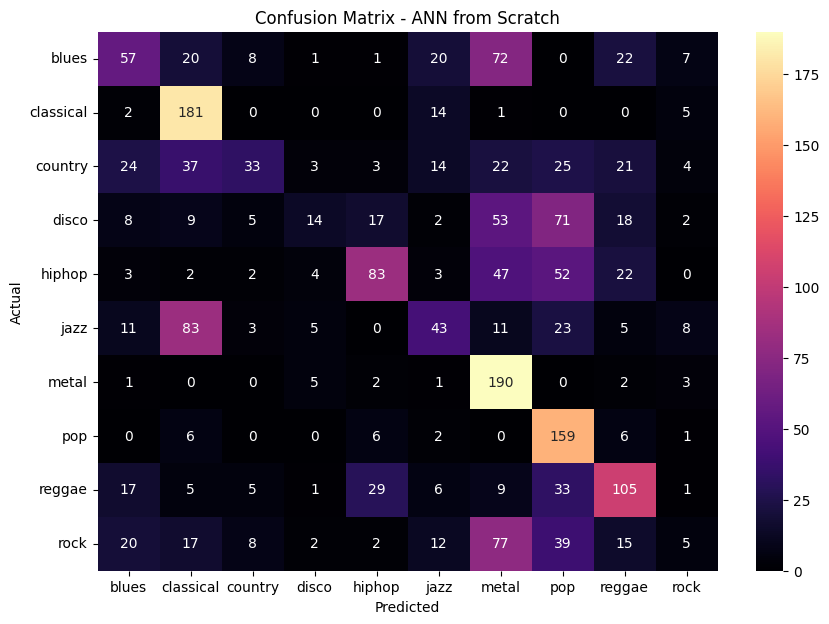


Classification Report:

              precision    recall  f1-score   support

       blues       0.40      0.27      0.32       208
   classical       0.50      0.89      0.64       203
     country       0.52      0.18      0.26       186
       disco       0.40      0.07      0.12       199
      hiphop       0.58      0.38      0.46       218
        jazz       0.37      0.22      0.28       192
       metal       0.39      0.93      0.55       204
         pop       0.40      0.88      0.55       180
      reggae       0.49      0.50      0.49       211
        rock       0.14      0.03      0.04       197

    accuracy                           0.44      1998
   macro avg       0.42      0.44      0.37      1998
weighted avg       0.42      0.44      0.37      1998



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_train_oh = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test_oh = ohe.transform(y_test.values.reshape(-1, 1))

# Neural Network from scratch
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            # Xavier Initialization
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(1. / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def relu(self, x):
        return np.where(x > 0, x, 0.01 * x)  # Leaky ReLU

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0.01)  # Leaky ReLU Derivative

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            a = self.relu(z)
            activations.append(a)
        z = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        z_values.append(z)
        a = self.softmax(z)
        activations.append(a)
        return activations, z_values

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-8)) / m

    def backward(self, activations, z_values, y_true):
        grads_w = [0] * len(self.weights)
        grads_b = [0] * len(self.biases)
        m = y_true.shape[0]
        delta = activations[-1] - y_true

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(activations[i].T, delta) / m
            grads_b[i] = np.sum(delta, axis=0, keepdims=True) / m

            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(z_values[i - 1])

        return grads_w, grads_b

    def update_parameters(self, grads_w, grads_b):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]

    def fit(self, X, y, epochs=300):
        for epoch in range(epochs):
            activations, z_values = self.forward(X)
            loss = self.compute_loss(y, activations[-1])
            grads_w, grads_b = self.backward(activations, z_values, y)
            self.update_parameters(grads_w, grads_b)

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)

# Train model
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_sizes=[256, 128], output_size=10, learning_rate=0.005)
nn.fit(X_train, y_train_oh, epochs=300)

# Predict
train_preds = nn.predict(X_train)
test_preds = nn.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, train_preds) * 100
test_acc = accuracy_score(y_test, test_preds) * 100
print(f"\nTrain Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ANN from Scratch")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, test_preds, target_names=label_encoder.classes_))